In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import warnings
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, array_to_img
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [4]:
pip install Pillow

Note: you may need to restart the kernel to use updated packages.


> **Load Dataset**

In [5]:
input_image = '/kaggle/input/animefacedataset/images'

In [6]:
image_list = []

for image in os.listdir(input_image):
    
    image_list.append(os.path.join(input_image,image))

In [7]:
image_list[:5]

['/kaggle/input/animefacedataset/images/35715_2011.jpg',
 '/kaggle/input/animefacedataset/images/48610_2014.jpg',
 '/kaggle/input/animefacedataset/images/34719_2011.jpg',
 '/kaggle/input/animefacedataset/images/40266_2012.jpg',
 '/kaggle/input/animefacedataset/images/4199_2002.jpg']

In [8]:
len(image_list)

63565

In [9]:
train_images = []

for path in image_list:
    img = Image.open(path)
    img = img.resize((64,64))
    image = np.array(img)
    train_images.append(image)

In [10]:
train_images = np.array(train_images)

In [11]:
train_images = train_images.reshape(train_images.shape[0],64,64,3).astype('float32')

In [12]:
# normalize (0,255) => (-1,1)   (255-127.5)/127.5 = 1 //////  (0-127.5)/127.5 = -1
train_images = (train_images - 127.5)/127.5

In [13]:
train_images[0]

array([[[ 0.28627452,  0.24705882,  0.07450981],
        [ 0.8509804 ,  0.81960785,  0.62352943],
        [ 0.2       ,  0.18431373, -0.04313726],
        ...,
        [ 0.24705882,  0.22352941, -0.09019608],
        [ 0.35686275,  0.3254902 ,  0.05098039],
        [ 0.827451  ,  0.77254903,  0.5529412 ]],

       [[ 1.        ,  1.        ,  0.8039216 ],
        [ 0.34117648,  0.30980393,  0.09803922],
        [-0.07450981, -0.08235294, -0.3254902 ],
        ...,
        [ 0.5058824 ,  0.49019608,  0.11372549],
        [-0.06666667, -0.09803922, -0.39607844],
        [ 0.5058824 ,  0.45882353,  0.20784314]],

       [[ 0.11372549,  0.08235294, -0.14509805],
        [-0.54509807, -0.5686275 , -0.8117647 ],
        [ 0.8509804 ,  0.8352941 ,  0.5372549 ],
        ...,
        [ 0.5294118 ,  0.5137255 ,  0.06666667],
        [ 0.01960784, -0.01176471, -0.38039216],
        [ 0.08235294,  0.04313726, -0.25490198]],

       ...,

       [[ 0.9764706 ,  1.        ,  0.9843137 ],
        [ 0

> **Create Generator**

In [14]:
# latent dimension for random noise
LATENT_DIM = 300
# weight initializer
WEIGHT_INIT = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
# no. of channels of the image
CHANNELS = 3 # for gray scale, keep it as 1



> **Generator Model**

In [15]:
model = Sequential(name='generator')

# 1d random noise
model.add(layers.Dense(8 * 8 * 512, input_dim=LATENT_DIM))
model.add(layers.ReLU())

# convert 1d to 3d
model.add(layers.Reshape((8, 8, 512)))

# upsample to 16x16
model.add(layers.Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same', kernel_initializer=WEIGHT_INIT))
model.add(layers.ReLU())

# upsample to 32x32
model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', kernel_initializer=WEIGHT_INIT))
model.add(layers.ReLU())

# upsample to 64x64
model.add(layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', kernel_initializer=WEIGHT_INIT))
model.add(layers.ReLU())

model.add(layers.Conv2D(CHANNELS, (4, 4), padding='same', activation='tanh'))

generator = model
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32768)             9863168   
                                                                 
 re_lu (ReLU)                (None, 32768)             0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 512)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 256)      2097408   
 nspose)                                                         
                                                                 
 re_lu_1 (ReLU)              (None, 16, 16, 256)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 128)      524416    
 ranspose)                                               

> **Discriminator Model**

In [16]:
model = Sequential(name='discriminator')
alpha = 0.2

# create conv layers
model.add(layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same', input_shape=(64, 64, 3)))
model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU(alpha=0.2))

model.add(layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same', input_shape=(64, 64, 3)))
model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU(alpha=0.2))

model.add(layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same', input_shape=(64, 64, 3)))
model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU(alpha=0.2))

model.add(layers.Conv2D(256, (4, 4), strides=(2, 2), padding='same', input_shape=(64, 64, 3)))
model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU(alpha=0.2))

model.add(layers.Conv2D(256, (4, 4), strides=(2, 2), padding='same', input_shape=(64, 64, 3)))
model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU(alpha=0.2))

model.add(layers.Flatten())
model.add(layers.Dropout(0.3))

# output class
model.add(layers.Dense(1, activation='sigmoid'))

discriminator = model
discriminator.summary()



Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        3136      
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 64)       256       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 128)      512       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)     

> **Create DCGAN**

In [17]:
class DCGAN(keras.Model):
    def __init__(self, generator, discriminator, latent_dim):
        super().__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.latent_dim = latent_dim
        self.g_loss_metric = keras.metrics.Mean(name='g_loss')
        self.d_loss_metric = keras.metrics.Mean(name='d_loss')
        
    @property
    def metrics(self):
        return [self.g_loss_metric, self.d_loss_metric]
    
    def compile(self, g_optimizer, d_optimizer, loss_fn):
        super(DCGAN, self).compile()
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer
        self.loss_fn = loss_fn
        
    def train_step(self, real_images):
        # get batch size from the data
        batch_size = tf.shape(real_images)[0]
        # generate random noise
        random_noise = tf.random.normal(shape=(batch_size, self.latent_dim))
        
        # train the discriminator with real (1) and fake (0) images
        with tf.GradientTape() as tape:
            # compute loss on real images
            pred_real = self.discriminator(real_images, training=True)
            # generate real image labels
            real_labels = tf.ones((batch_size, 1))
            # label smoothing
            real_labels += 0.05 * tf.random.uniform(tf.shape(real_labels))
            d_loss_real = self.loss_fn(real_labels, pred_real)
            
            # compute loss on fake images
            fake_images = self.generator(random_noise)
            pred_fake = self.discriminator(fake_images, training=True)
            # generate fake labels
            fake_labels = tf.zeros((batch_size, 1))
            d_loss_fake = self.loss_fn(fake_labels, pred_fake)
            
            # total discriminator loss
            d_loss = (d_loss_real + d_loss_fake) / 2
            
        # compute discriminator gradients
        gradients = tape.gradient(d_loss, self.discriminator.trainable_variables)
        # update the gradients
        self.d_optimizer.apply_gradients(zip(gradients, self.discriminator.trainable_variables))
        
        
        # train the generator model
        labels = tf.ones((batch_size, 1))
        # generator want discriminator to think that fake images are real
        with tf.GradientTape() as tape:
            # generate fake images from generator
            fake_images = self.generator(random_noise, training=True)
            # classify images as real or fake
            pred_fake = self.discriminator(fake_images, training=True)
            # compute loss
            g_loss = self.loss_fn(labels, pred_fake)
            
        # compute gradients
        gradients = tape.gradient(g_loss, self.generator.trainable_variables)
        # update the gradients
        self.g_optimizer.apply_gradients(zip(gradients, self.generator.trainable_variables))
        
        # update states for both models
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        
        return {'d_loss': self.d_loss_metric.result(), 'g_loss': self.g_loss_metric.result()}

In [18]:
class DCGANMonitor(keras.callbacks.Callback):
    def __init__(self, num_imgs=25, latent_dim=300):
        self.num_imgs = num_imgs
        self.latent_dim = latent_dim
        # create random noise for generating images
        self.noise = tf.random.normal([25, latent_dim])

    def on_epoch_end(self, epoch, logs=None):
        # generate the image from noise
        g_img = self.model.generator(self.noise)
        # denormalize the image
        g_img = (g_img * 127.5) + 127.5
        g_img.numpy()
        
    def on_train_end(self, logs=None):
        self.model.generator.save('generator.h5')

> **Training**

In [19]:
dcgan = DCGAN(generator=generator, discriminator=discriminator, latent_dim=LATENT_DIM)

In [20]:
D_LR = 0.0001 
G_LR = 0.0003
dcgan.compile(g_optimizer=Adam(learning_rate=G_LR, beta_1=0.5), d_optimizer=Adam(learning_rate=D_LR, beta_1=0.5), loss_fn=BinaryCrossentropy())

In [21]:
N_EPOCHS = 50
dcgan.fit(train_images, epochs=N_EPOCHS, callbacks=[DCGANMonitor()])

Epoch 1/50
1987/1987 [==============================] - 156s 70ms/step - d_loss: -0.3444 - g_loss: 9.5930
Epoch 2/50
1987/1987 [==============================] - 141s 71ms/step - d_loss: -1.1300 - g_loss: 14.7825
Epoch 3/50
1987/1987 [==============================] - 142s 71ms/step - d_loss: -0.2078 - g_loss: 10.4776
Epoch 4/50
1987/1987 [==============================] - 142s 72ms/step - d_loss: 0.7903 - g_loss: 1.2772
Epoch 5/50
1987/1987 [==============================] - 143s 72ms/step - d_loss: 0.6936 - g_loss: 1.3035
Epoch 6/50
1987/1987 [==============================] - 142s 71ms/step - d_loss: 0.6630 - g_loss: 1.2612
Epoch 7/50
1987/1987 [==============================] - 142s 71ms/step - d_loss: 0.6074 - g_loss: 1.4514
Epoch 8/50
1987/1987 [==============================] - 142s 71ms/step - d_loss: 0.5736 - g_loss: 1.5713
Epoch 9/50
1987/1987 [==============================] - 142s 71ms/step - d_loss: 0.5432 - g_loss: 1.6972
Epoch 10/50
1987/1987 [===========================

> **Results**

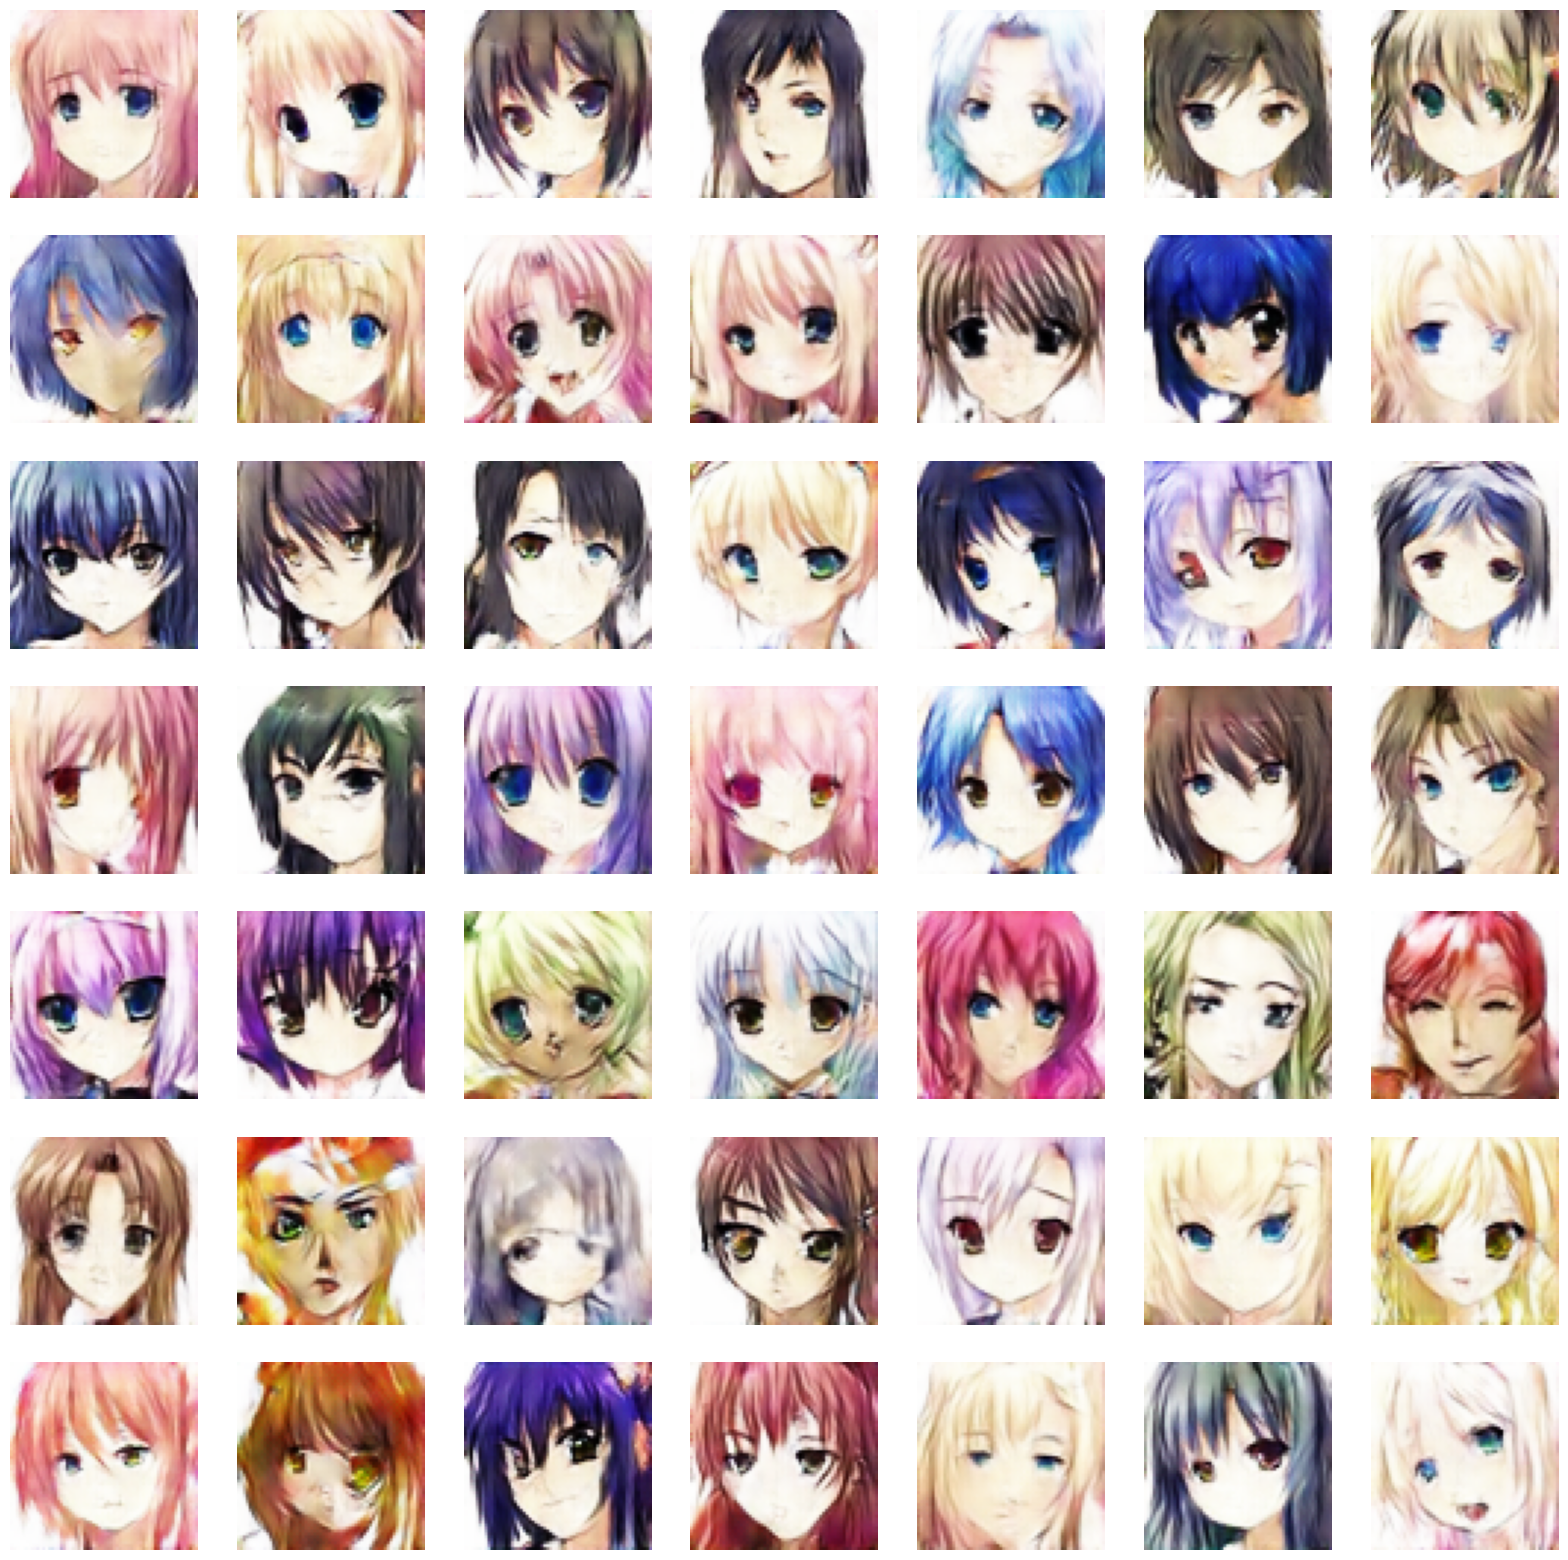

In [22]:
# plot 49 generated images
plt.figure(figsize=(20,20))

for i in range(49):
    plt.subplot(7,7,i+1)
    #generate random noise for each image
    noise=tf.random.normal([1,300])
    mg = dcgan.generator(noise)
    #denormalize
    mg = (mg*127.5)+127.5
    
    mg.numpy()
    image = array_to_img(mg[0])
    
    plt.imshow(image)
    plt.axis('off')